## CS 794 Question 4

In [ ]:
# Import packages
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit, logit
import random

In [ ]:
def prepare_mnist(dig1, dig2):
    # Load all mnist data from Keras
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Filter for the specified digits
    trainX = x_train[(y_train == dig1) | (y_train == dig2)]
    trainYr = y_train[(y_train == dig1) | (y_train == dig2)]
    testX = x_test[(y_test == dig1) | (y_test == dig2)]
    testYr = y_test[(y_test == dig1) | (y_test == dig2)]

    # Calculate the mean and add it for train and test
    q = trainX.mean()

    trainX = trainX.reshape(trainX.shape[0], -1)
    testX = testX.reshape(testX.shape[0], -1)

    q_train = np.full((trainX.shape[0], 1), q)
    trainXr = np.hstack((trainX, q_train))
    q_test = np.full((testX.shape[0], 1), q)
    testXr = np.hstack((testX, q_test))

    # Flip the signs for rows with digit 1
    trainXr[(trainYr==dig1),:] *= -1
    testXr[(testYr==dig1),:] *= -1

    return trainXr, testXr, trainYr, testYr

In [ ]:
# A function to calculate the gradient
def compute_gradient(a, x, gamma):
    atx = np.dot(a, x)
    gradient = a * expit(atx) + gamma * x
    return gradient

def sgd_logistic(trainXr, gamma, stepsizefunc, numit):
    # Initialize weights to zeros
    num_features = trainXr.shape[1]
    xopt = np.zeros(num_features)
    total = np.zeros(num_features)

    for k in range(numit):
        a = trainXr[np.random.randint(0,trainXr.shape[0])]

        # Compute the gradient
        gradient = compute_gradient(a, xopt, gamma)

        # Compute the step size using the provided stepsize function
        alpha = stepsizefunc(a, xopt, k, gamma)

        # Update the weights using the computed gradient and step size
        xopt -= alpha * gradient
        total += xopt

    return total/numit

Code from Question 3

In [ ]:
def find_mu0(c):
    precomputed_values = []
    for i in range(20+1):
        precomputed_values.append([i, i+i*np.exp(i)])
    for i in range(len(precomputed_values) - 1):
        if precomputed_values[i][1] <= c <= precomputed_values[i + 1][1]:
            x0 = precomputed_values[i][0]
            y0 = precomputed_values[i][1]
            x1 = precomputed_values[i + 1][0]
            y1 = precomputed_values[i + 1][1]

            mu0 = x0 + (c - y0) / (y1 - y0) * (x1 - x0)
            return mu0

    print('Can\'t find mu0 with current precomputed values available')
    return None

def newt(gamma, aTa):
    c = aTa / gamma
    mu = find_mu0(c)
    for i in range(5):
        exp_mu = np.exp(mu)
        mu_new = mu - (mu + mu*exp_mu - c)/(1 + exp_mu + mu*exp_mu)
        mu = mu_new

    theta = mu / aTa
    f_opt = np.log(1 + np.exp(-theta * aTa)) + 1/2 * gamma * (theta**2) * aTa
    return f_opt

SGD

In [ ]:
# Apply the given formula
def stoch_polyak(a, x, gamma, gammab):
    atx = np.dot(a, x)
    grad = a * expit(atx) + gamma * x
    fk_a = np.log(1 + np.exp(atx)) + (gamma / 2) * np.linalg.norm(x)**2
    ata = np.dot(a, a)
    fmin = newt(gamma, ata)

    alpha = min(gammab, (2 * (fk_a - fmin)) / np.linalg.norm(grad)**2)
    return alpha

In [21]:
# Functions for displaying the image
def display_image(trainXr, trainYr, image_index):
    img = trainXr[image_index][:-1].reshape(28,28)
    if img.sum()<0:
        img = -img
    plt.imshow(img, cmap="gray")
    if trainYr[image_index] == 1:
        plt.title(f"True label: {trainYr[image_index].item()} \n Misclassified as 3")

    else:
        plt.title(f"True label: {trainYr[image_index].item()} \n Misclassified as 1")
    plt.show()
    plt.close()

    return trainYr[image_index].item()

def random_index_misclassified_img(arr):
    valid_indices = [i for i, v in enumerate(arr) if v >= 0]

    if not valid_indices:
        return None

    return random.choice(valid_indices)

def choose_image_index(average_x_lst, trainXr, trainYr):
    selected_x, stepsizefn, numit = average_x_lst[11]
    print("Display the image:")
    print(f"{stepsizefn}")
    print(f"Number of iterations: {numit}")

    missclassified_sample_idx = random_index_misclassified_img(np.dot(trainXr, selected_x))

    if missclassified_sample_idx is not None:
        display_image(trainXr, trainYr, missclassified_sample_idx)
    else:
        print("All images predicted correctly.")

The argument "stepsizefunc" is a function of the following form:
alpha = ψ(a, x, k, gamma)

In [22]:
def driver():
    [trainXr, testXr, trainYr, testYr] = prepare_mnist(1, 3)
    print(
        f"testXr's shape: {testXr.shape}, "
        f"testYr's shape: {testYr.shape}, "
        f"trainXr's shape: {trainXr.shape}, "
        f"trainYr's shape: {trainYr.shape}"
    )
    print("")

    # Initilization
    gamma = 2.0
    gammab = 10e4
    L_g2 = 4 * gamma**2
    # c = L_g2 / gamma**2
    c = 4
    numit1 = 50
    numit2 = 5000

    stepsizefunc1 = lambda a, x, k, gamma: 1e-2 / (4 * gamma)
    stepsizefunc2 = lambda a, x, k, gamma: 1e-5 / (4 * gamma)
    stepsizefunc3 = lambda a, x, k, gamma: 1 / (gamma * (c + 0.75 * k))
    stepsizefunc4 = lambda a, x, k, gamma: stoch_polyak(a, x, gamma, gammab)

    # Run the logstic regression
    # Loop through different step size functions and numbers of iterations
    step_size_functions = [stepsizefunc1, stepsizefunc2, stepsizefunc3, stepsizefunc4]
    numit_lst = [50, 5000]

    # Create a dictionary to associate descriptions with lambda functions
    step_size_function_info = {
        "Step Size Function 1": stepsizefunc1,
        "Step Size Function 2": stepsizefunc2,
        "Step Size Function 3": stepsizefunc3,
        "Step Size Function 4": stepsizefunc4
    }

    average_x_lst = []

    for step_description, step_size_func in step_size_function_info.items():
        print(f"{step_description}")
        for numit in numit_lst:
            print(f"Number of iterations: {numit}")
            train_error_list = []
            test_error_list = []
            for run in range(3): # Perform three runs for each parameter set
                average_x = sgd_logistic(trainXr, gamma, step_size_func, numit)
                average_x_lst.append((average_x, step_description, numit))

                train_aTx = np.dot(trainXr, average_x)
                test_aTx = np.dot(testXr, average_x)

                train_pred = np.sum((train_aTx >= 0) / train_aTx.shape[0])
                test_pred = np.sum((test_aTx >= 0) / test_aTx.shape[0])

                train_error_list.append(train_pred)
                test_error_list.append(test_pred)

            train_error_list = np.array(train_error_list)
            test_error_list = np.array(test_error_list)
            print("train error min = {}, max = {}, mean = {}"\
                  .format(train_error_list.min(), train_error_list.max(), train_error_list.mean()))
            print("test error min = {}, max = {}, mean = {}\n"\
                  .format(test_error_list.min(), test_error_list.max(), test_error_list.mean()))
        print("================================================================")
    choose_image_index(average_x_lst, trainXr, trainYr)

testXr's shape: (2145, 785), testYr's shape: (2145,), trainXr's shape: (12873, 785), trainYr's shape: (12873,)

Step Size Function 1
Number of iterations: 50
train error min = 0.04264740153810301, max = 0.04754136564903286, mean = 0.045599316398663874
test error min = 0.0386946386946387, max = 0.04242424242424242, mean = 0.040870240870240875

Number of iterations: 5000
train error min = 0.012040705352287734, max = 0.0146042103627748, mean = 0.013154146922499286
test error min = 0.005128205128205128, max = 0.006526806526806527, mean = 0.005594405594405594

Step Size Function 2
Number of iterations: 50
train error min = 0.019265128563660375, max = 0.034102384836479455, mean = 0.028302131075377407
test error min = 0.012587412587412587, max = 0.027972027972027972, mean = 0.022222222222222223

Number of iterations: 5000
train error min = 0.008545016701623553, max = 0.009554882311815428, mean = 0.00898521453170719
test error min = 0.002797202797202797, max = 0.004662004662004662, mean = 0.00

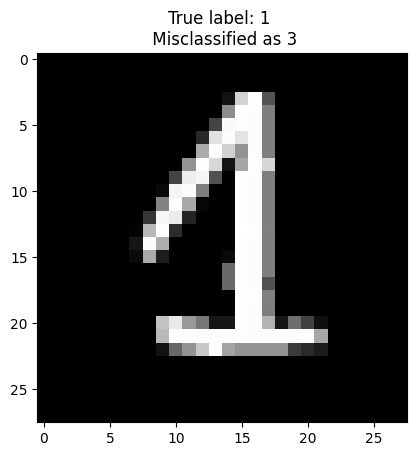

In [29]:
driver()